python_ml_221020

## 교차검증 & 샘플링 & 그리드 서치
- 정확도를 올리다 (X)
- Accuracy Better Model (X)
- Accuracy Stable Model (O)

In [1]:
import pandas as pd

In [2]:
wine = pd.read_csv('https://bit.ly/wine_csv_data')

### Input & Target으로 1차 분리

In [3]:
data = wine[['alcohol', 'sugar','pH']].to_numpy() # 매개변수
target = wine['class'].to_numpy() # 종속변수
data.shape, target.shape

((6497, 3), (6497,))

### 세트 분리
- 기존) : train/test 세트로 분리
- 지금) : train/valid/test 세트로 분리


- train/test 8:2로 분리

In [4]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    data, target, random_state=42, test_size=0.2
)

train_input.shape, test_input.shape, train_target.shape, test_target.shape

((5197, 3), (1300, 3), (5197,), (1300,))

In [5]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size = 0.2, random_state=42
)
sub_input.shape, val_input.shape, sub_target.shape, val_target.shape

((4157, 3), (1040, 3), (4157,), (1040,))

- 모형 만들고, 모형 평가
  + 기존) test 데이터 바로 평가 (Unseen Data) / 미래에 올 데이터
  + 지금) val 데이터만 평가

In [6]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


In [7]:
print(dt.score(test_input, test_target))


0.8569230769230769


## 교차검증

In [8]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)

print(scores)

{'fit_time': array([0.00945735, 0.00735688, 0.00781965, 0.00763392, 0.007195  ]), 'score_time': array([0.00100875, 0.00085282, 0.00094795, 0.00084662, 0.00085163]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [9]:
scores['test_score']

array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])

In [10]:
import numpy as np

# 검증 데이터 점수
np.mean(scores['test_score'])

0.855300214703487

- StratifiedKFold 활용
  + 통계용어 : 층화추출 (비율에 근거해서 추출하기)
- 기존 방법 : 임의 추출 방식 (무작위 방식)
- 분류모형
  + 분류기준 / 레드와인 개수, 화이트와인 개수

In [11]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


- StratifiedKFold() 세부 옵션 지정

In [12]:
# n_splits : 몇번 교차 검증 할건지 숫자 10
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터의 개념
- 기존) 수동으로 조정, 하나씩 값을 확인하는 형태
  - ridge(), Lasso(), alpha값 조정
  - decision tree, max_depth 값 조정

- 지금) 자동화개발 --> 머신러닝 엔지니어

In [13]:
from sklearn.model_selection import GridSearchCV

# 모형 만들기
dt = DecisionTreeClassifier(random_state=42)

# 하이퍼파라미터 투입
params = {'max_depth': [2,3,4,5,6,7]}
gs = GridSearchCV(dt, params, n_jobs=-1)

# 모형 학습 --> 7번 수행
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7]})

- 가장 최적화된 max_depth 확인

In [14]:
print(gs.best_params_)

{'max_depth': 5}


In [15]:
best_dt = gs.best_estimator_
print(best_dt.score(train_input, train_target))

0.8672310948624207


In [16]:
gs.cv_results_['mean_test_score']

result = pd.DataFrame({
    'max_depth' : [2,3,4,5,6,7],
    'score' : gs.cv_results_['mean_test_score']
})

result

,max_depth,score
0,2,0.813936
1,3,0.841256
2,4,0.853378
3,5,0.857804
4,6,0.855880
5,7,0.855301


In [17]:
# 하이퍼파라미터 투입
params = {'max_depth': [2,3,4,5,6,7],
          'min_impurity_decrease' : np.arange(0.0001,0.001,0.01), # 노드 분할시, 불순도 감소, 최저량 지정
          'min_samples_split' : range(2,100,10)
          }
gs = GridSearchCV(dt, params, n_jobs=-1)

# 모형 학습 --> 7번 수행
gs.fit(train_input, train_target)

print(gs.best_params_)

best_dt = gs.best_estimator_
print(best_dt.score(train_input, train_target))

{'max_depth': 7, 'min_impurity_decrease': 0.0001, 'min_samples_split': 92}
0.8793534731575909


## 랜덤 서치
- 매개변수 값의 목록을 전달하는 것이 아니다.
- 매개변수가 샘플링할 수 있는 객체를 전달하는 것이다.

- 정수 무작위 추출(randint)

In [18]:
from scipy.stats import uniform, randint

rgen = randint(0,10)
np.unique(rgen.rvs(100),return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([12,  5, 13, 12,  5, 12, 11, 13,  6, 11]))

- 실수 무작위 추출(uniform)

In [19]:
ugen = uniform(0,1)
ugen.rvs(10)

array([0.33229248, 0.91277718, 0.99244341, 0.45474779, 0.44992452,
       0.76346446, 0.07875431, 0.27297032, 0.80258835, 0.86218937])

In [20]:
from sklearn.model_selection import RandomizedSearchCV

# 하이퍼파라미터 투입
params = {'max_depth': randint(2,50),
          'min_impurity_decrease' : uniform(0.0001,0.1), # 노드 분할시, 불순도 감소, 최저량 지정
          'min_samples_split' : randint(2,50)
          }

# n_jobs=-1 --> 코어를 직렬이 아닌 병렬로 계산하겠다는 뜻
# 랜덤서치
rs = RandomizedSearchCV(dt, params, n_iter=100,random_state=42, n_jobs=-1)

rs.fit(train_input,train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe48edf9c90>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe48edb4d90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe48edb4910>},
                   random_state=42)

In [21]:
print(rs.best_params_)

best_dt = rs.best_estimator_
print(best_dt.score(train_input, train_target))

{'max_depth': 39, 'min_impurity_decrease': 0.00017787658410143285, 'min_samples_split': 22}
0.9053299980758129


## 주요 정리
- 샘플링 중요 : 데이터가 편향적일 수 있다.
- 과대적합 방지 : 하이퍼파라미터 튜닝을 진행한다.
  + 그리드 서치 : 비추천
  + 랜덤 서치 : 추천
  + 각 모델의 도움말을 잘 살펴본다.


## 랜덤포레스트 (Random Forest)
- Decision Tree
- 데이터 샘플은 무작위로 뽑는다. (행 조정)
- 데이터 컬럼 개수가 매우 많음
  + 1천개
  + 컬럼 개수의 조합 (무작위 선택 필요)
  + 독립된 모형
- 데이터셋이 클 때, 매우 큰 효과 발휘

In [23]:
train_input.shape, test_input.shape, train_target.shape, test_target.shape

((5197, 3), (1300, 3), (5197,), (1300,))

In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1,random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809


### 특성 중요도
- 각 데이터의 특성(Feature)이 존재.
- 현재 사용하는 알고리즘에서 중요도를 표시해주는 것

In [28]:
rf.fit(train_input, train_target)

# print(rf.n_features_)

print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


- 알코올,      도수,        산도
- [0.23167441 0.50039841 0.26792718]


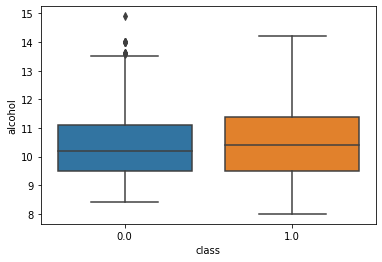

In [33]:
import seaborn as sns

# sns.scatterplot(data=wine, x='pH', y='sugar', hue='class')
sns.boxplot(data=wine, x='class', y='alcohol')

- 복원 추출
  + 한번도 추출이 안된 샘플이 있을 수도 있다.

In [34]:
rf = RandomForestClassifier(n_jobs=-1, oob_score = True, random_state=42)
rf.fit(train_input, train_target)
print(rf.oob_score_) # 검증 세트와 비슷한 느낌.
print(rf.score(train_input,train_target))
print(rf.score(test_input,test_target))

0.8934000384837406
0.996921300750433
0.8892307692307693


## 확률적 경사하강법
- 점진적 학습
  - 대표 알고리즘 : 확률적 경사 하강법 (Stochastic Gradient Descent)
  + 확률적 : 무작위 데이터 
- 훈련세트 분리
  + 샘플 뽑기
    + 확률적 경사하강법 : 1개씩 뽑기
    + 미니배치 경사 하강법 : 여러개씩 뽑기
    + 배치 경사 하강법 : 몽땅 꺼내기
  + 조금씩 경사 및 기울기를 따라 이동
  + 모든 훈련세트 소진 : 1 에포크 끝.

- 손실함수 (loss function)
  + 머신러닝 알고리즘이 얼마나 잘 못맞추느냐 측정하는 기준.
  + 손실 함수의 값은 작을수록 좋음

## 그레이디언트 부스팅
- 처음에 샘플을 뽑고, 경사하강법을 적용
  + 사용하는 모델은 결정 트리

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
gd = GradientBoostingClassifier(n_estimators = 500,
                                learning_rate=0.2,
                                subsample=0.5, # 전체 훈련 세트
                                random_state=42)

scores = cross_validate(gd, train_input,train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9434289514154802 0.8751230843266453


## XGBoost vs LightGBM
- Decision Tree
- 노드가 분기, 속도 차이 존재
  + LightGBM > XGBoost
- GPU 지원 여부
  + 기존) 선형회귀, 결정트리, 랜덤포레스트, 일반 부스팅 (지원X)
  + XGBoost, LightGBM (지원O)
- 공통적인 특징 (문법상 미세한 차이 발생)
  + Scikit-Learn과 연동된 API
  + 독자적인 API
  + 약간의 문법적인 혼동이 옴

기존) pandas 데이터프레임 --> numpy 배열 --> Scikit-Learn

LightGBM) pandas 데이터프레임 --> numpy 배열 --> Dataset API --> 모델

XGBoost) pandas 데이터프레임 --> numpy 배열 --> DMatrix --> 모델

### Scikit-Learn API

In [40]:
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method='hist', random_state=42)

scores = cross_validate(xgb,train_input,train_target, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8824322471423747 0.8726214185237284


In [41]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)

scores = cross_validate(lgb,train_input,train_target, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9338079582727165 0.8789710890649293


머신러닝 프로세스
- 데이터 수집
- 데이터 전처리
  + Feature Engineering (표준화), 각 수치 데이터의 단위가 다름.
- 머신러닝 모델
  + 분류
  + 회귀 (수치 예측)
  + KNN, 선형회귀, 로지스틱회귀, 결정트리(랜덤포레스트 등), 경사하강법
- 하이퍼파라미터, 교차검증
  + 그리드 서치
  + 랜덤 서치
- 평가지표
  + 분류 : 정확도
  + 회귀 : MAE